In [1]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

C:\Users\aarya\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\aarya\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\aarya\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Download the MovieLens dataset and prepare the data

In [2]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

Then, we load the data into a Pandas DataFrame and perform some basic preprocessing.

In [3]:
movies = pd.read_csv("ml-latest-small/movies.csv")
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")
print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


Let's inspect a sample instance of the `ratings` DataFrame.

In [54]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


Next, let's check a sample instance of the `movies` DataFrame.

In [55]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


Implement two utility functions for the `movies` DataFrame.

In [56]:

def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]


def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]


## Construct the Movies graph

### Step 1: create the weighted edges between movies.

In [60]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

rated_movies = ratings[ratings.rating >= min_rating]

movies_grouped_by_users = list(rated_movies.groupby("userId"))
# print(movies_grouped_by_users)
for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    
    current_movies = list(group[1]["movieId"])
#     print(current_movies)
    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

Compute movie rating frequencies: 100%|█████████████████████████████████████████████| 573/573 [00:00<00:00, 719.06it/s]


### Step 2: create the graph with the nodes and the edges

To reduce the number of edges between nodes, we only add an edge between movies
if the weight of the edge is greater than `min_weight`.

In [6]:
min_weight = 10
D = math.log(sum(item_frequency.values()))

movies_graph = nx.Graph()
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Creating the movie graph: 100%|████████████████████████████████████████████| 298586/298586 [00:00<00:00, 553072.85it/s]


Let's display the total number of nodes and edges in the graph.
Note that the number of nodes is less than the total number of movies,
since only the movies that have edges to other movies are added.

In [0]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Let's display the average node degree (number of neighbours) in the graph.

In [0]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

### Step 3: Create vocabulary and a mapping from tokens to integer indices

In [62]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}


## Implement the biased random walk

In [63]:

def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    
    for neighbor in neighbors:
        if neighbor == previous:
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            weights.append(graph[current][neighbor]["weight"])
        else:
            weights.append(graph[current][neighbor]["weight"] / q)

    
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            walk = [node]
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            walk = [vocabulary_lookup[token] for token in walk]
            walks.append(walk)

    return walks


## Generate training data using the biased random walk

You can explore different configurations of `p` and `q` to different results of
related movies.

In [9]:
p = 1
q = 1
num_walks = 5
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████████████████████████████████████████| 1405/1405 [00:05<00:00, 261.23it/s]

Number of walks generated: 7025


In [26]:
walks

[[829, 740, 927, 632, 848, 265, 19, 978, 640, 294],
 [641, 239, 428, 18, 207, 181, 48, 402, 10, 329],
 [1096, 778, 1153, 686, 891, 656, 18, 1173, 743, 73],
 [1094, 261, 1119, 261, 257, 261, 782, 725, 23, 173],
 [479, 482, 404, 844, 391, 766, 394, 387, 764, 755],
 [1261, 45, 244, 540, 853, 207, 208, 165, 374, 181],
 [298, 23, 817, 520, 44, 284, 7, 381, 172, 364],
 [237, 23, 130, 19, 669, 160, 217, 787, 1121, 391],
 [1020, 643, 311, 650, 66, 16, 1275, 17, 655, 29],
 [32, 434, 245, 420, 418, 66, 1064, 645, 639, 119],
 [1355, 556, 678, 718, 562, 455, 16, 1369, 645, 655],
 [462, 855, 449, 1132, 313, 714, 723, 717, 939, 942],
 [290, 256, 317, 246, 565, 563, 1106, 375, 880, 408],
 [1051, 563, 829, 833, 12, 183, 561, 406, 160, 737],
 [733, 35, 259, 201, 611, 520, 533, 532, 533, 378],
 [47, 73, 576, 644, 378, 31, 461, 441, 25, 1],
 [752, 52, 454, 330, 665, 669, 85, 774, 670, 546],
 [327, 918, 1057, 918, 67, 32, 1320, 306, 717, 656],
 [678, 793, 1202, 554, 542, 456, 31, 265, 20, 461],
 [1211, 67

## Generate positive and negative examples

### Generate examples

In [34]:

def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights) , pairs


num_negative_samples = 4
targets, contexts, labels, weights, pairs = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|███████████████████████████████████| 7025/7025 [00:11<00:00, 610.45it/s]


Let's display the shapes of the outputs

In [35]:
print(pairs)
print(targets)
print(contexts)
print(labels)
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

[[52, 615], [173, 651], [52, 618], [1147, 951], [611, 206], [239, 739], [1146, 763], [1103, 815], [611, 1103], [27, 1147], [1146, 354], [239, 37], [1146, 1202], [239, 612], [239, 560], [354, 1046], [611, 1188], [611, 536], [1103, 52], [27, 1348], [354, 60], [52, 827], [27, 545], [173, 837], [611, 1146], [173, 1021], [1103, 1146], [27, 1146], [1103, 174], [52, 825], [354, 1338], [611, 212], [1146, 353], [52, 307], [1147, 1144], [173, 900], [1103, 6], [60, 165], [354, 414], [1146, 611], [239, 1146], [239, 82], [173, 1397], [1147, 703], [173, 1260], [52, 239], [239, 842], [354, 173], [611, 354], [1103, 1264], [354, 795], [27, 1239], [173, 354], [354, 848], [173, 629], [239, 1271], [52, 846], [1147, 415], [60, 1146], [354, 862], [60, 173], [27, 243], [52, 544], [239, 413], [611, 7], [173, 995], [1147, 354], [60, 27], [1146, 1109], [239, 1203], [27, 1030], [611, 698], [1147, 52], [1103, 21], [1147, 611], [1146, 566], [1147, 505], [1103, 354], [27, 1293], [1147, 1352], [1147, 390], [52, 1326

### Convert the data into `tf.data.Dataset` objects

In [17]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

In [19]:
print(dataset)

<PrefetchDataset shapes: ({target: (1024,), context: (1024,)}, (1024,), (1024,)), types: ({target: tf.int32, context: tf.int32}, tf.int32, tf.int32)>


## Train the skip-gram model

In [36]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

### Implement the model

In [64]:

def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    target_embeddings = embed_item(inputs["target"])
    context_embeddings = embed_item(inputs["context"])
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


### Train the model

We instantiate the model and compile it.

In [51]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

Let's plot the model.

In [52]:
keras.utils.plot_model(
    model, show_shapes=True, show_dtype=True, show_layer_names=True,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Now we train the model on the `dataset`.

In [53]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
860/860 [==============================] - 5s 5ms/step - loss: 2.4532
Epoch 2/10
860/860 [==============================] - 4s 5ms/step - loss: 2.3455
Epoch 3/10
860/860 [==============================] - 4s 5ms/step - loss: 2.3374
Epoch 4/10
860/860 [==============================] - 4s 5ms/step - loss: 2.3331
Epoch 5/10
860/860 [==============================] - 4s 5ms/step - loss: 2.3287
Epoch 6/10
860/860 [==============================] - 4s 5ms/step - loss: 2.3244
Epoch 7/10
860/860 [==============================] - 4s 5ms/step - loss: 2.3208
Epoch 8/10
860/860 [==============================] - 4s 5ms/step - loss: 2.3179
Epoch 9/10
860/860 [==============================] - 4s 5ms/step - loss: 2.3153
Epoch 10/10
860/860 [==============================] - 4s 5ms/step - loss: 2.3130


Finally we plot the learning history.

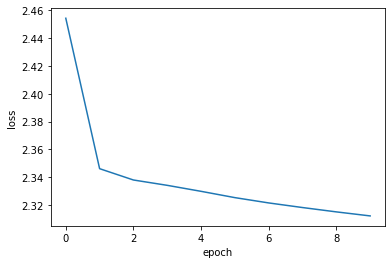

In [50]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Analyze the learnt embeddings.

In [0]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

### Find related movies

Define a list with some movies called `query_movies`.

In [0]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

Get the embeddings of the movies in `query_movies`.

In [0]:
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

Compute the [consine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between the embeddings of `query_movies`
and all the other movies, then pick the top k for each.

In [0]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)
_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

Display the top related movies in `query_movies`.

In [0]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()